Duplicate key in file WindowsPath('C:/Users/tauyu/anaconda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 257 ('font.family:  IPAexGothic')


<IPython.core.display.Javascript object>


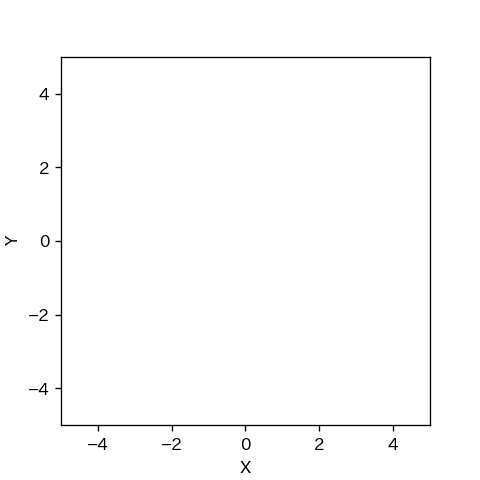

In [1]:
import sys
sys.path.append("../scripts/")
import matplotlib.animation as anm
from mcl import *

In [2]:
class ResetMcl(Mcl):
    def __init__(self,envmap,init_pose,num,motion_noise_stds={"nn":0.19,"no":0.001,"on":0.13,"oo":0.2},
                distance_dev_rate=0.14,direction_dev=0.05,alpha_threshold=0.001,expansion_rate=0.2):
        super().__init__(envmap,init_pose,num,motion_noise_stds,distance_dev_rate,direction_dev)
        self.alpha_threshold=alpha_threshold
        self.expansion_rate=expansion_rate
        self.counter=0
        
    def random_reset(self):
         for p in self.particles:
                p.pose=np.array([np.random.uniform(-5.0,5,0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
                p.weight=1/len(self.particles)
    
    def sensor_resetting_draw(self,particle,landmark_pos,ell_obs,phi_obs):
             ##パーティクルの位置を決める##
                psi=np.random.uniform(-np.pi,np.pi) #ランドマークからの方角を選ぶ
                ell=norm(loc=ell_obs,scale=(ell_obs*self.distance_dev_rate)**2).rvs() #ランドマークからの距離を選ぶ
                particle.pose[0]=landmark_pos[0]+ell*math.cos(psi)
                particle.pose[1]=landmark_pos[1]+ell*math.sin(psi)
                
            ##パーティクルの向きを決める##
                phi=norm(loc=phi_obs,scale=(self.direction_dev)**2).rvs() #ランドマークが見える向きを決める
                particle.pose[2]=math.atan2(landmark_pos[1]-particle.pose[1],landmark_pos[0]-particle.pose[0])-phi
            
                particle.weight=1.0/len(self.particles) #重みを1/Nに
            
    def sensor_resetting(self,observation):
        d=list([obs[0][0] for obs in observation])
        if len(d)==2:
            nearest_obs=np.argmin([obs[0][0] for obs in observation]) #最小値の位置=最小値の位置を求める関数(idを含むセンサ値のリスト)
            values1, landmark_id1=observation[nearest_obs]#単なるセンサ値のリスト
            b = sorted(d).index(sorted(d)[1]) #ただのセンサ値
            values2, landmark_id2 = observation[b]   #bの型がおかしい可能性がある b(センサ値)の場所をobservation[]のかっこに入れる
            for p in self.particles:
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id1].pos, *values1)
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id2].pos, *values2)
                
            print(d)
            
            
        elif len(d)==1:
            nearest_obs3=np.argmin([obs[0][0] for obs in observation])
            values3, landmark_id3=observation[nearest_obs3]
            
            for p in self.particles:
                self.sensor_resetting_draw(p, self.map.landmarks[landmark_id3].pos, *values3)
                
            print(d)
            
    def expansion_resetting(self):
        for p in self.particles:
            p.pose+=multivariate_normal(cov=np.eye(3)*(self.expansion_rate**2)).rvs()
            p.weight=1.0/len(self.particles)
            
    def observation_update(self,observation):
        for p in self.particles:
            p.observation_update(observation,self.map,self.distance_dev_rate,self.direction_dev)
     
        self.set_ml()
        
        if sum([p.weight for p in self.particles]) < self.alpha_threshold:
            self.counter += 1
            if self.counter < 5:
                self.expansion_resetting() #expansion_resettingに変更
            else:
                self.sensor_resetting(observation)
        else:
            self.counter=0
            self.resampling()

C:\Users\tauyu\anaconda\lib\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [3]:
def trial_kidnap(animation):
    time_interval=0.1
    world=World(30,time_interval,debug=not animation)
    
    ##地図を生成して3つランドマークを追加##
    m=Map()
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)
    
    ##ロボットを作る##
    init_pose=np.array([np.random.uniform(-5.0,5.0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
    robot_pose=np.array([np.random.uniform(-5.0,5.0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
    pf=ResetMcl(m,init_pose,100)
    a=EstimationAgent(time_interval,0.2,10.0/180*math.pi,pf)
    r=Robot(robot_pose,sensor=Camera(m),agent=a,color="red")
    world.append(r)
#  phantom_prob=0.1
    world.draw()
    #world.ani.save()
    return(r.pose,pf.ml.pose)

<IPython.core.display.Javascript object>


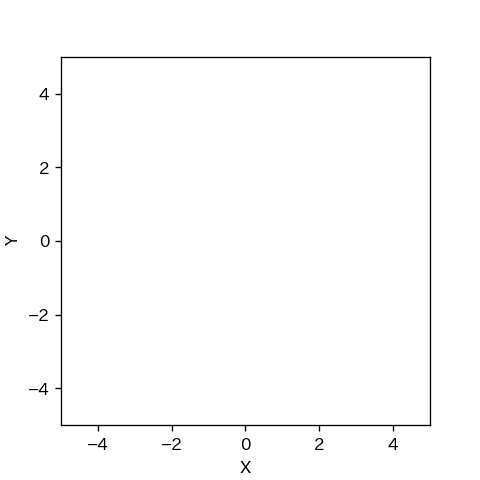

(array([-4.27881452,  1.7269737 ,  2.82440474]),
 array([ 0.26279419, -4.62025655, -0.20526848]))

In [4]:
trial_kidnap(True)

In [5]:
if __name__=='__main__': ###mclglobal1exec
    ok=0
    for i in range(1000):
        actual, estm=trial_kidnap(False)
        diff = math.sqrt((actual[0]-estm[0])**2 + (actual[1]-estm[1])**2)
        print(i, "真値:",actual, "推定値:", estm, "誤差:", diff)
        if diff<=1.0:
            ok += 1
            print(ok)

[4.305499995693799]
0 真値: [-0.40503564  5.63460661  3.50435455] 推定値: [-0.425121    5.47391786  3.460321  ] 誤差: 0.16193917007112965
1
[6.885254394358673]
[5.756786199578506]
1 真値: [ 0.98559384 -3.4851867   7.05976804] 推定値: [ 0.8584621  -3.30480054  6.74546575] 誤差: 0.22068449353473799
2
[4.680754599981855]
[4.052250596032552]
[2.6602185620519347, 5.991519302959218]
2 真値: [ 0.45537011 -1.03568518  7.81717589] 推定値: [-0.06174325 -0.64676874  1.43631636] 誤差: 0.6470411310678048
3
[4.815584205391899]
3 真値: [-0.49339705  4.83469334  7.71358921] 推定値: [-0.5444725   4.62802779  1.20029848] 誤差: 0.21288342831491897
4
[5.749793974775415]
[6.739362878597705]
[3.312860596552099]
4 真値: [ 1.2765536  -1.85960041  5.32759426] 推定値: [ 3.42354062 -3.23884236  2.99302781] 誤差: 2.5518349554998614
5 真値: [-3.17974155  0.50971022  3.37194265] 推定値: [-3.40701847  0.03073794  3.10194937] 誤差: 0.5301596412111893
5
[4.659398870921708]
[3.651184367730295, 4.070063873172913]
6 真値: [1.63463611 2.06112246 8.63291427] 推定値: [1

C:\Users\tauyu\section_advanced_localization\../scripts\ideal_robot.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4,4))


[1.636095053382132]
[5.319536735274065]
20 真値: [5.06674667 3.07454964 7.4704173 ] 推定値: [ 8.08969883 -6.5937605   5.91175338] 誤差: 10.129879604247936
[3.488282828720143]
21 真値: [3.13175514 1.77335697 3.78714871] 推定値: [2.98298212 1.91831045 3.76364078] 誤差: 0.20771356321393275
14
22 真値: [ 3.49606424 -5.28698354  7.16221294] 推定値: [-0.30498251 -6.16603281  5.28639303] 誤差: 3.901369502236777
[4.77823602134065]
23 真値: [-3.74664152  2.48847697  4.19047571] 推定値: [-3.56270838  2.19005573  3.51098077] 誤差: 0.35055190614038917
15
[1.5353713552301174]
24 真値: [-1.23505823 -1.46784402  5.31821429] 推定値: [-1.42999713 -2.10002891  5.3866896 ] 誤差: 0.661557939319377
16
[4.132168148942089]
[5.638569737875615]
25 真値: [-3.22092219 -2.31280222  6.38133494] 推定値: [ 2.16215656 -8.15797745  1.74414791] 誤差: 7.946295380603415
[4.849142483930064]
[2.8007712445307367, 6.011633851442642]
[2.6914985791737585, 6.980245635774217]
[2.7660343527953453, 5.992667073747667]
[2.800074250183949, 5.229852497446216]
[7.9842744599855